In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

In [2]:
# ignore warnings because they are annoying
import warnings
warnings.filterwarnings('ignore')

In [5]:
Jobs_data=pd.read_csv('all_upwork_jobs_2024-02-07-2024-03-24.csv')#read the csv file

In [6]:
Jobs_data.head()# to get the head of the dataset

,title,link,published_date,is_hourly,hourly_low,hourly_high,budget,country
0,Experienced Media Buyer For Solar Pannel and R...,https://www.upwork.com/jobs/Experienced-Media-...,2024-02-17 09:09:54+00:00,False,NaN,NaN,500.0,NaN
1,Full Stack Developer,https://www.upwork.com/jobs/Full-Stack-Develop...,2024-02-17 09:09:17+00:00,False,NaN,NaN,1100.0,United States
2,SMMA Bubble App,https://www.upwork.com/jobs/SMMA-Bubble-App_%7...,2024-02-17 09:08:46+00:00,True,10.0,30.0,NaN,United States
3,Talent Hunter Specialized in Marketing,https://www.upwork.com/jobs/Talent-Hunter-Spec...,2024-02-17 09:08:08+00:00,True,NaN,NaN,NaN,United States
4,Data Engineer,https://www.upwork.com/jobs/Data-Engineer_%7E0...,2024-02-17 09:07:42+00:00,False,NaN,NaN,650.0,India


In [7]:
Jobs_data.tail()# to get the tail of the dataset

,title,link,published_date,is_hourly,hourly_low,hourly_high,budget,country
244823,Need Facebook advertising experts to launch pr...,https://www.upwork.com/jobs/Need-Facebook-adve...,2024-03-24 13:28:38+00:00,True,20.0,100.0,NaN,Zambia
244824,Digital/Telemarketing/Sales/OutSide Sales,https://www.upwork.com/jobs/Digital-Telemarket...,2024-03-24 13:40:52+00:00,False,NaN,NaN,100.0,Sri Lanka
244825,WordPress Template Edits,https://www.upwork.com/jobs/WordPress-Template...,2024-03-24 13:37:50+00:00,True,5.0,30.0,NaN,United States
244826,ELEMENTOR PRO For quick fix (Wordpress),https://www.upwork.com/jobs/ELEMENTOR-PRO-For-...,2024-03-24 13:52:15+00:00,False,NaN,NaN,15.0,France
244827,Creating a UGC Ad for Our Mobile Game,https://www.upwork.com/jobs/Creating-UGC-for-O...,2024-03-24 13:53:00+00:00,False,NaN,NaN,50.0,Israel


In [8]:
print("\n Summary Statistics:")
print(Jobs_data.describe())# describe the dataset


 Summary Statistics:
          hourly_low   hourly_high          budget
count  102422.000000  98775.000000   103891.000000
mean       17.339644     41.970610      911.473564
std        18.140065     47.850892    15729.738834
min         3.000000      3.000000        5.000000
25%         8.000000     20.000000       25.000000
50%        15.000000     30.000000      100.000000
75%        20.000000     50.000000      300.000000
max       998.000000    999.000000  1000000.000000


In [9]:
Jobs_data.info()# to get the information of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244828 entries, 0 to 244827
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   title           244827 non-null  object 
 1   link            244827 non-null  object 
 2   published_date  244828 non-null  object 
 3   is_hourly       244828 non-null  bool   
 4   hourly_low      102422 non-null  float64
 5   hourly_high     98775 non-null   float64
 6   budget          103891 non-null  float64
 7   country         239751 non-null  object 
dtypes: bool(1), float64(3), object(4)
memory usage: 13.3+ MB


In [10]:
Jobs_data.columns# to get the columns of the dataset

Index(['title', 'link', 'published_date', 'is_hourly', 'hourly_low',
       'hourly_high', 'budget', 'country'],
      dtype='object')

In [11]:
 # Identify the numerical and the categorical columns as:

numerical_columns= Jobs_data.select_dtypes (include=['number']).columns.to_list()

categorical_columns= Jobs_data.select_dtypes (include=['object']).columns.to_list()

In [12]:
numerical_columns# numerical columns of the dataset

['hourly_low', 'hourly_high', 'budget']

In [13]:
categorical_columns# categorical columns of the dataset

['title', 'link', 'published_date', 'country']

In [14]:
Jobs_data.isnull().sum()# findings the null value of the dataset

,0
title,1
link,1
published_date,0
is_hourly,0
hourly_low,142406
hourly_high,146053
budget,140937
country,5077


In [15]:
Jobs_data.dtypes# find the types of the dataset

,0
title,object
link,object
published_date,object
is_hourly,bool
hourly_low,float64
hourly_high,float64
budget,float64
country,object


#Task 1: Analyze the correlation between job title keywords and offered salaries

In [16]:
# Convert columns to numeric and handle errors
Jobs_data['hourly_low'] = pd.to_numeric(Jobs_data['hourly_low'], errors='coerce')
Jobs_data['hourly_high'] = pd.to_numeric(Jobs_data['hourly_high'], errors='coerce')
Jobs_data['budget'] = pd.to_numeric(Jobs_data['budget'], errors='coerce')

In [17]:
# Fill NaN values in 'budget' with the average of 'hourly_low' and 'hourly_high'
Jobs_data['budget'] = Jobs_data.apply(
    lambda row: row['budget'] if pd.notna(row['budget']) else (row['hourly_low'] + row['hourly_high']) / 2,
    axis=1
)

In [18]:
Jobs_data.isnull().sum()

,0
title,1
link,1
published_date,0
is_hourly,0
hourly_low,142406
hourly_high,146053
budget,42162
country,5077


In [19]:
# Filling title with unknown
Jobs_data['title'].fillna('Unknown',inplace=True)

# Filling link with unknown
Jobs_data['link'].fillna('Unknown',inplace=True)

# Filling hourly_low with mean
Jobs_data['hourly_low'].fillna(Jobs_data['hourly_low'].mean(), inplace=True)

# Filling hourly_high with mean
Jobs_data['hourly_high'].fillna(Jobs_data['hourly_high'].mean(), inplace=True)

# Filling budget with mean
Jobs_data['budget'].fillna(Jobs_data['budget'].mean(), inplace=True)

# Filling country with Unknown
Jobs_data['country'].fillna('Unknown',inplace=True)

In [20]:
Jobs_data.isnull().sum()# handle the missing value of the dataset

,0
title,0
link,0
published_date,0
is_hourly,0
hourly_low,0
hourly_high,0
budget,0
country,0


In [21]:
Jobs_data.duplicated().sum()# get the duplicate value if any in the dataset

0

In [22]:
Jobs_data.describe().T#describe the dataset in the table form

,count,mean,std,min,25%,50%,75%,max
hourly_low,244828.0,17.339644,11.732855,3.0,15.0,17.339644,17.339644,998.0
hourly_high,244828.0,41.970610,30.393569,3.0,40.0,41.970610,41.970610,999.0
budget,244828.0,481.720824,10254.437026,3.0,20.0,50.000000,481.720824,1000000.0


# New Section

In [23]:
import seaborn as sns #import the liabrary

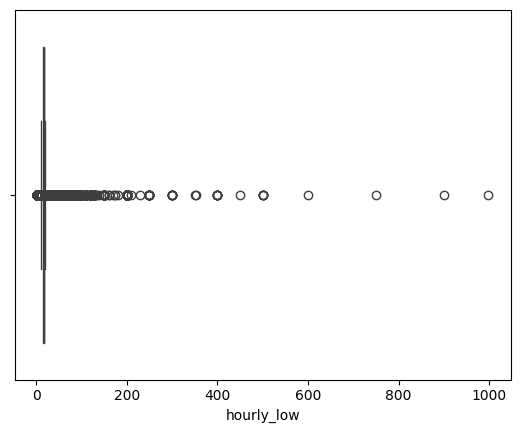

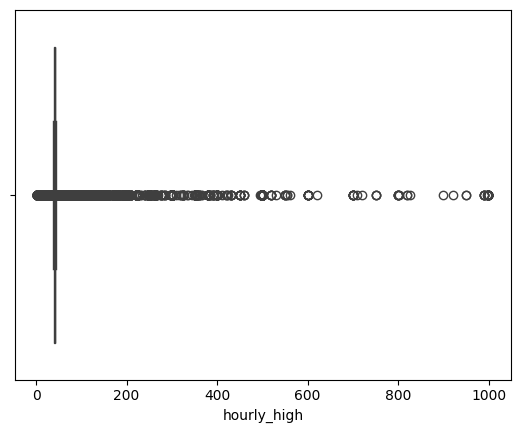

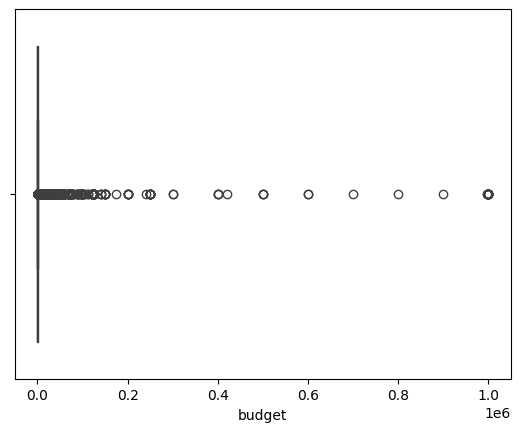

In [24]:
import warnings# import the warnings
warnings.filterwarnings("ignore")
for i in Jobs_data.select_dtypes(include="number").columns:
   sns.boxplot(data=Jobs_data,x=i)
   plt.show()

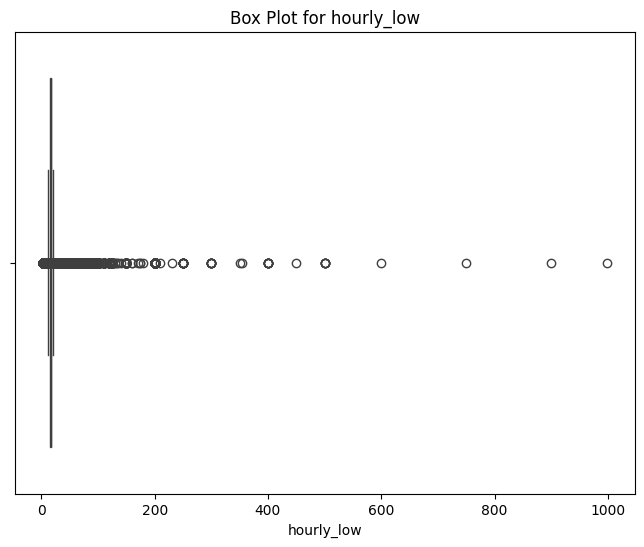

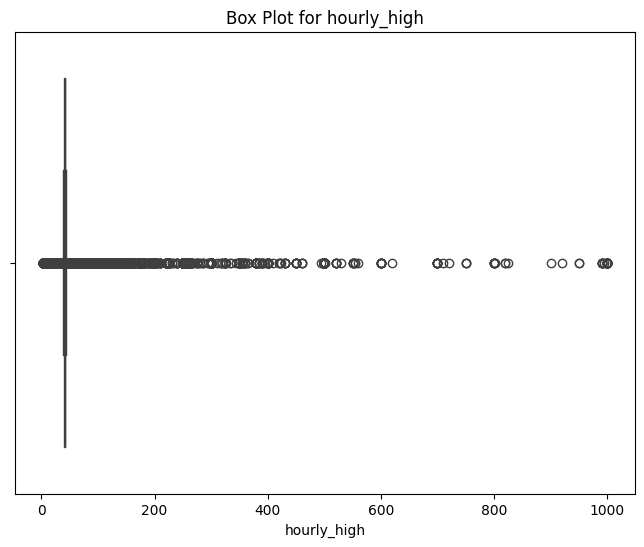

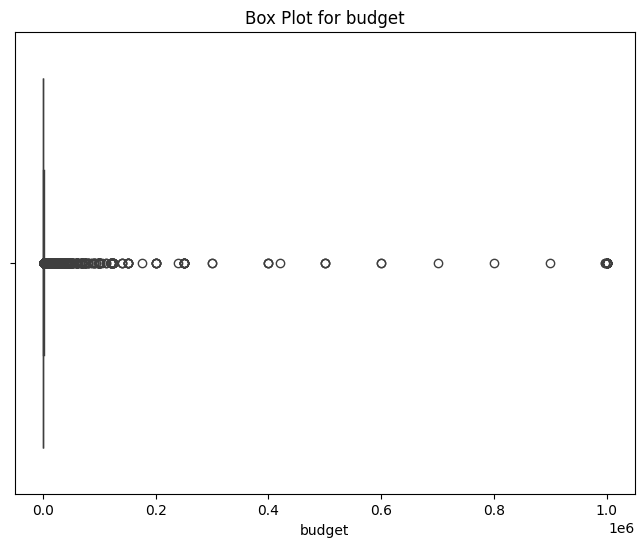

In [25]:
# List of numerical columns in the "train_data" DataFrame
numerical_columns = ['hourly_low','hourly_high','budget']

# box plots for each numerical column
for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=Jobs_data, x=col)
    plt.title(f'Box Plot for {col}')
    plt.show()

#Treating outliers

In [26]:
# for columns

# Select the desired columns using a list of column names
selected_columns = Jobs_data[['hourly_low','hourly_high','budget']]

# Calculate percentiles using the selected columns
q1 = selected_columns.quantile(0.25)  # Get q1 for all columns
q3 = selected_columns.quantile(0.75)  # Get q3 for all columns


# Calculate IQR for each column
iqr = q3 - q1

# Calculate lower and upper bounds for each column
lower_range = q1 - 1.5 * iqr
upper_range = q3 + 1.5 * iqr

# Identifying outliers for each column
outliers_lower = Jobs_data[selected_columns < lower_range]
outliers_upper = Jobs_data[selected_columns > upper_range]

print(f"Outliers (lower bound):\n{outliers_lower.values}")
print(f"Outliers (upper bound):\n{outliers_upper.values}")

# Clip the values within the specified range for each column
Jobs_data[['hourly_low','hourly_high','budget']] = selected_columns.clip(lower_range, upper_range, axis=1)

Outliers (lower bound):
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... 30.0 nan nan]
 ...
 [nan nan nan ... 30.0 nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Outliers (upper bound):
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [27]:
def df_wisker(col):
    q1,q3=np.percentile(col,[25,75])
    iqr=q3-q1
    lw=q1-1.5*iqr
    uw=q3+1.5*iqr
    return lw,uw

In [28]:
Jobs_data['avg_salary'] = (Jobs_data['hourly_low'] + Jobs_data['hourly_high']) /2

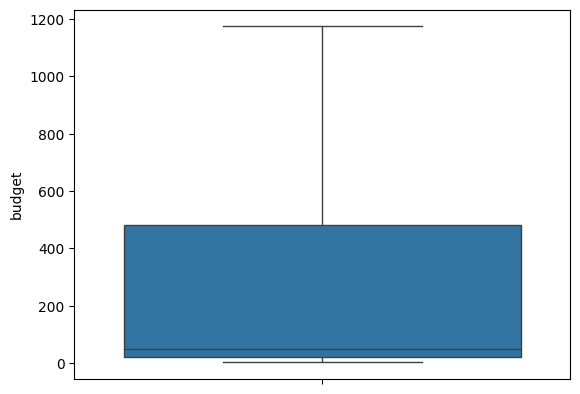

In [29]:
import seaborn as sns

# Change the function call to use the correct function name
sns.boxplot(Jobs_data[i])

# Display the plot
plt.show()

In [30]:
# Replace outliers with the mean
mean = Jobs_data[['hourly_low','hourly_high','budget','avg_salary']].mean()
# Apply the df_wisker function to each column to get the lower and upper whiskers
lw = Jobs_data[['hourly_low','hourly_high','budget','avg_salary']].apply(df_wisker).apply(lambda x: x[0])
uw = Jobs_data[['hourly_low','hourly_high','budget','avg_salary']].apply(df_wisker).apply(lambda x: x[1])
# Replace outliers with the mean for each column using the calculated whiskers
for col in ['hourly_low','hourly_high','budget','avg_salary']:
    Jobs_data.loc[((Jobs_data[col] < lw[col]) | (Jobs_data[col] > uw[col])), col] = mean[col]

print(Jobs_data)

                                                    title  \
0       Experienced Media Buyer For Solar Pannel and R...   
1                                    Full Stack Developer   
2                                         SMMA Bubble App   
3                  Talent Hunter Specialized in Marketing   
4                                           Data Engineer   
...                                                   ...   
244823  Need Facebook advertising experts to launch pr...   
244824          Digital/Telemarketing/Sales/OutSide Sales   
244825                           WordPress Template Edits   
244826            ELEMENTOR PRO For quick fix (Wordpress)   
244827              Creating a UGC Ad for Our Mobile Game   

                                                     link  \
0       https://www.upwork.com/jobs/Experienced-Media-...   
1       https://www.upwork.com/jobs/Full-Stack-Develop...   
2       https://www.upwork.com/jobs/SMMA-Bubble-App_%7...   
3       https://www.upw

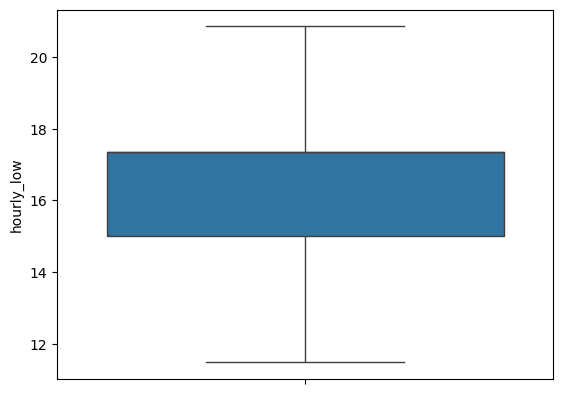

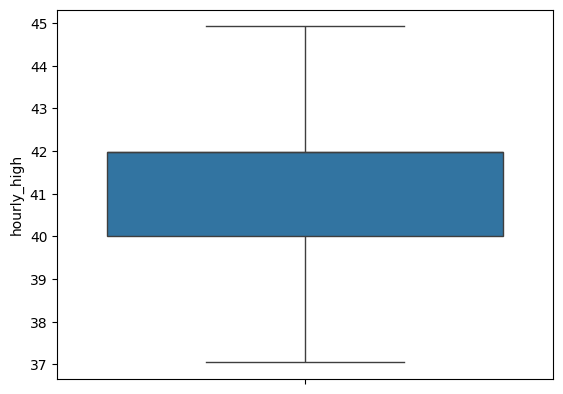

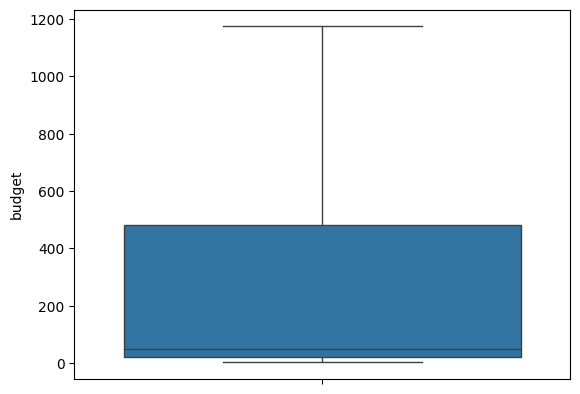

In [31]:
for col in ['hourly_low','hourly_high','budget',]:
    sns.boxplot(Jobs_data[col])
    plt.show()

In [32]:
 #for avg_salary columns

Q1 = Jobs_data['avg_salary'].quantile(0.25)
Q3 = Jobs_data['avg_salary'].quantile(0.75)

#interquartile range (IQR)
IQR = Q3 - Q1

# lower and upper bounds for outlier detection
lower_range = Q1 - 1.5 * IQR
upper_range = Q3 + 1.5 * IQR

# Identifying outliers in the "Customers" column
outliers_lower = Jobs_data[Jobs_data['avg_salary'] < lower_range]
outliers_upper = Jobs_data[Jobs_data['avg_salary'] > upper_range]

print(f"Outliers (lower bound): {outliers_lower['avg_salary'].values}")
print(f"Outliers (upper bound): {outliers_upper['avg_salary'].values}")


Outliers (lower bound): [26.73057212 26.73057212 26.73057212 ... 26.73057212 26.73057212
 26.73057212]
Outliers (upper bound): [31.40985977 31.40985977 30.96326247 ... 31.46326247 31.46326247
 31.40985977]


In [33]:
# Filling hourly_low with mean
Jobs_data['hourly_low'].fillna(Jobs_data['hourly_low'].mean(), inplace=True)
# Filling hourly_high with mean
Jobs_data['hourly_high'].fillna(Jobs_data['hourly_high'].mean(), inplace=True)
# Filling hourly_high with mean
Jobs_data['avg_salary'].fillna(Jobs_data['avg_salary'].mean(), inplace=True)
# Filling hourly_high with mean
Jobs_data['budget'].fillna(Jobs_data['budget'].mean(), inplace=True)

In [34]:
median = Jobs_data[['avg_salary', 'hourly_high', 'hourly_low']].median()

# Access the lower and upper whiskers for each column separately
lower_whisker_avg_salary = lw['avg_salary']
upper_whisker_avg_salary = uw['avg_salary']
lower_whisker_hourly_high = lw['hourly_high']
upper_whisker_hourly_high = uw['hourly_high']
lower_whisker_hourly_low = lw['hourly_low']
upper_whisker_hourly_low = uw['hourly_low']

# Replace outliers in each column with its respective median
for col, lower, upper, med in zip(['avg_salary', 'hourly_high', 'hourly_low'],
                                 [lower_whisker_avg_salary, lower_whisker_hourly_high, lower_whisker_hourly_low],
                                 [upper_whisker_avg_salary, upper_whisker_hourly_high, upper_whisker_hourly_low],
                                 median):
    Jobs_data.loc[((Jobs_data[col] < lower) | (Jobs_data[col] > upper)), col] = med

print(Jobs_data)

                                                    title  \
0       Experienced Media Buyer For Solar Pannel and R...   
1                                    Full Stack Developer   
2                                         SMMA Bubble App   
3                  Talent Hunter Specialized in Marketing   
4                                           Data Engineer   
...                                                   ...   
244823  Need Facebook advertising experts to launch pr...   
244824          Digital/Telemarketing/Sales/OutSide Sales   
244825                           WordPress Template Edits   
244826            ELEMENTOR PRO For quick fix (Wordpress)   
244827              Creating a UGC Ad for Our Mobile Game   

                                                     link  \
0       https://www.upwork.com/jobs/Experienced-Media-...   
1       https://www.upwork.com/jobs/Full-Stack-Develop...   
2       https://www.upwork.com/jobs/SMMA-Bubble-App_%7...   
3       https://www.upw

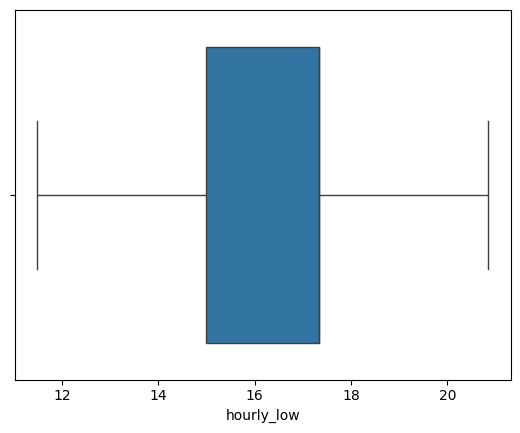

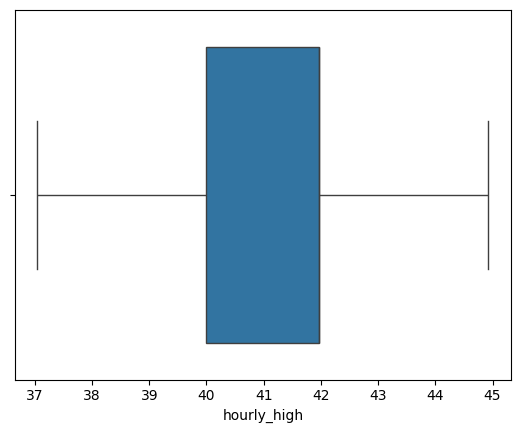

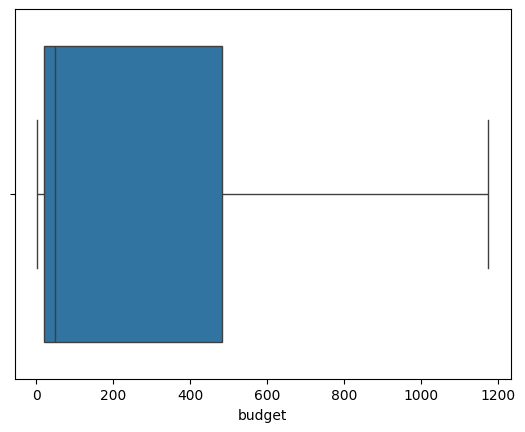

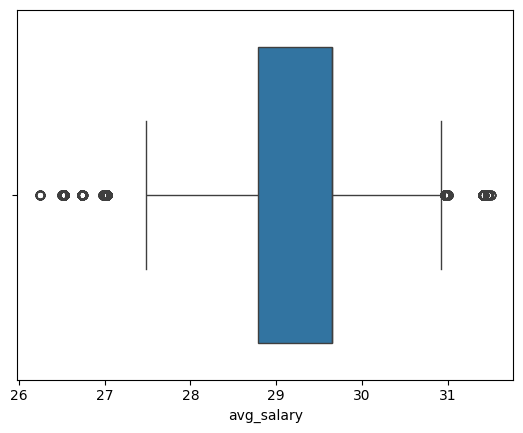

In [35]:
for i in Jobs_data.select_dtypes(include="number").columns:
   sns.boxplot(data=Jobs_data,x=i)
   plt.show()

In [36]:
# The 'salary' column can now be directly assigned from 'budget'
Jobs_data['salary'] = Jobs_data['budget']

# Drop rows with missing salary
Jobs_data.dropna(subset=['salary'], inplace=True)

In [37]:
# Convert 'title' to lowercase
Jobs_data['title'] = Jobs_data['title'].str.lower()

In [38]:
import nltk
# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [39]:
# Initialize the CountVectorizer
from nltk.corpus import stopwords  # Import stopwords

vectorizer = CountVectorizer(stop_words=stopwords.words('english'))

In [40]:
# Fit and transform the 'title' column
title_matrix = vectorizer.fit_transform(Jobs_data['title'])

In [41]:
# Convert salary to a dense array
salary = Jobs_data['salary'].values

In [42]:
# Compute correlations using sparse matrix operations
# Calculate the mean of the salary
mean_salary = salary.mean()
# Calculate the deviations from the mean
deviation_salary = salary - mean_salary
# Convert deviations to a sparse matrix
deviation_salary_sparse = csr_matrix(deviation_salary).T

In [43]:
# Calculate the correlation coefficient for each keyword
correlations = (title_matrix.T @ deviation_salary_sparse).toarray().flatten() / (title_matrix.shape[0] - 1)

In [44]:
# Create a DataFrame for correlations
correlation_df = pd.DataFrame({
    'keyword': vectorizer.get_feature_names_out(),
    'correlation': correlations
})

In [45]:
# Calculate average hourly rate and store it in 'average_hourly'
Jobs_data['average_hourly'] = (Jobs_data['hourly_low'] + Jobs_data['hourly_high']) / 2
average_hourly = Jobs_data[['title', 'average_hourly']].groupby('title').mean()

# Now you can proceed with the concatenation
analysis_Jobs_data = pd.concat([Jobs_data[['average_hourly']],correlation_df],axis=1)
analysis_Jobs_data.head()

,average_hourly,keyword,correlation
0,29.655127,00,0.008347
1,29.655127,000,0.096885
2,24.267310,000045a,0.000508
3,29.655127,0001,0.001149
4,29.655127,0002,0.001149


In [46]:
# Sort the correlations and get the top 20
top_keywords = correlation_df.sort_values(by='correlation', ascending=False).head(20)

In [47]:
import seaborn as sns

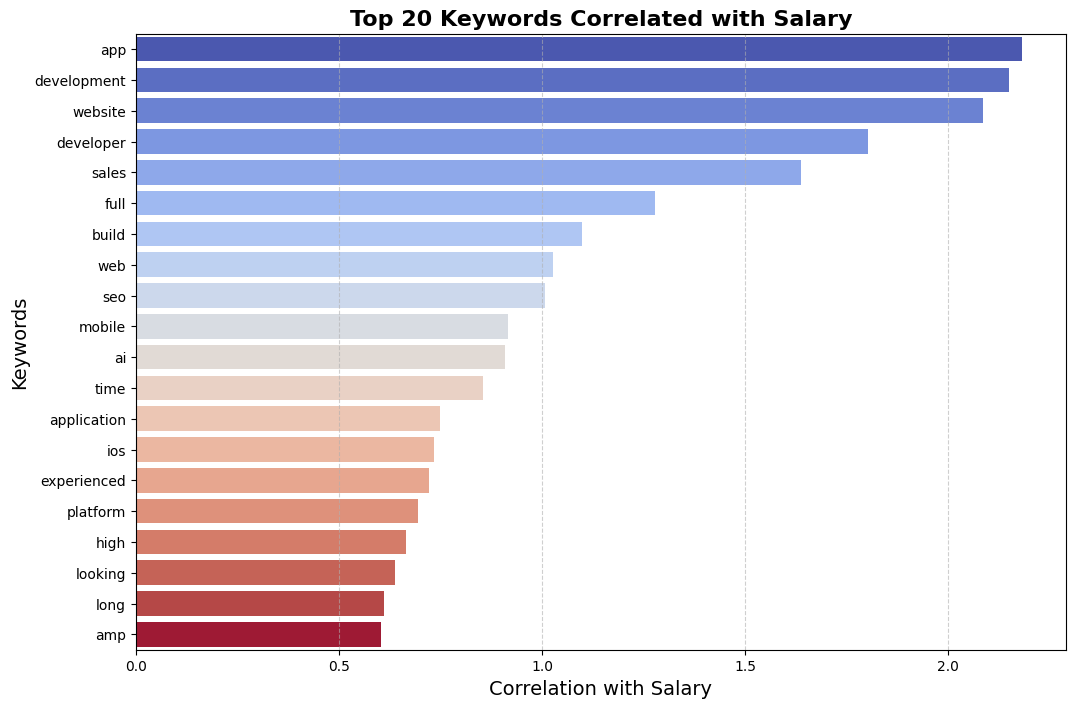

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a custom color palette using a gradient
cmap = sns.color_palette("coolwarm", as_cmap=True)
colors = cmap(np.linspace(0, 1, len(top_keywords)))  # Generate gradient colors

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=top_keywords['correlation'], y=top_keywords['keyword'], palette=colors)
plt.title('Top 20 Keywords Correlated with Salary', fontsize=16, fontweight='bold')
plt.xlabel('Correlation with Salary', fontsize=14)
plt.ylabel('Keywords', fontsize=14)

# Adding grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()


# Insights:-
Highlights which keywords (e.g., specific skills, job roles, certifications) have the strongest positive or negative correlation with salary.
Allows stakeholders to identify the top 20 influential keywords.

Data-Driven Decisions:

For Job Seekers: Focus on keywords with high positive correlations to improve resumes and profiles.
For Recruiters: Understand which keywords predict higher salary expectations for better alignment of candidate selection.

Interpretation of Correlation:

Positive Correlation: Keywords that are often associated with higher salaries.
Negative Correlation: Keywords that might correlate with lower salaries or entry-level positions.

Visual Comparison:
The horizontal bar chart makes it easy to compare correlation values across multiple keywords.



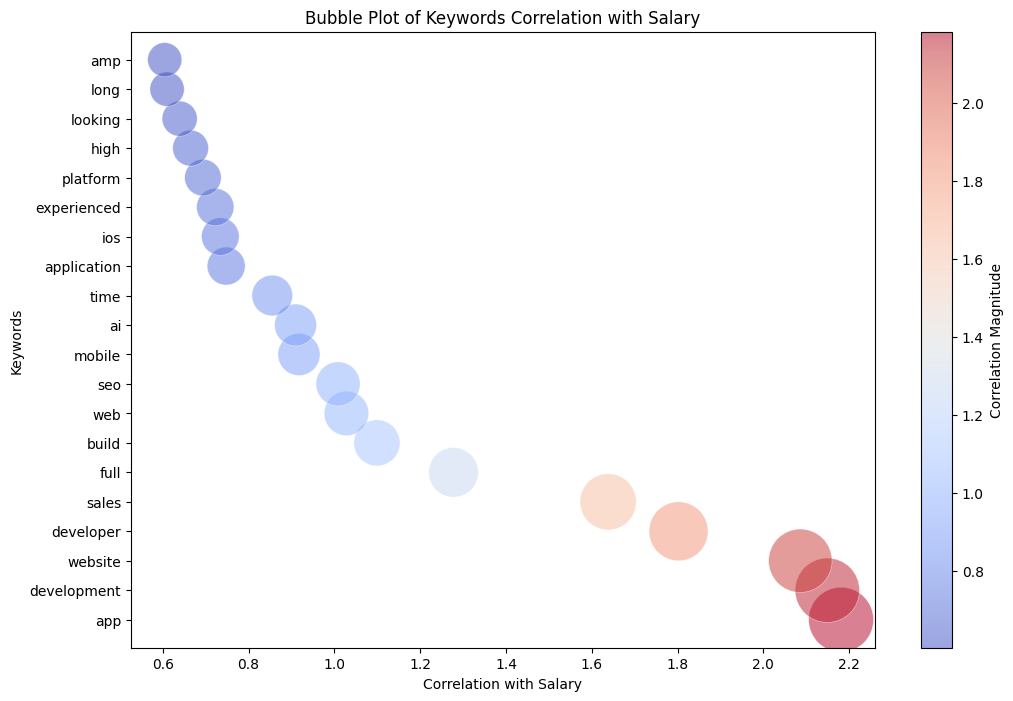

In [49]:
import matplotlib.pyplot as plt

# Bubble Plot
plt.figure(figsize=(12, 8))
bubble_size = abs(top_keywords['correlation']) * 1000  # Adjust size for better visualization
plt.scatter(top_keywords['correlation'], top_keywords['keyword'], s=bubble_size, alpha=0.5, c=top_keywords['correlation'], cmap='coolwarm', edgecolors='w', linewidth=0.5)
plt.title('Bubble Plot of Keywords Correlation with Salary')
plt.xlabel('Correlation with Salary')
plt.ylabel('Keywords')
plt.colorbar(label='Correlation Magnitude')
plt.show()


#Combines correlation with salary (x-axis), keywords category (y-axis), and magnitude of correlation (bubble size and color).

Correlation Strength:

The position of the bubble on the x-axis indicates the strength of the correlation (positive or negative) between the keyword and salary.
Keywords further to the right are more positively correlated with salary, while those on the left are negatively correlated.

Keyword Identification:

The y-axis lists the keywords, making it easy to identify which keyword is associated with a particular correlation.
Magnitude of Correlation:

The size of the bubble represents the absolute value of the correlation. Larger bubbles indicate a stronger relationship (either positive or negative)

Color Encoding:

The color of the bubble (from the coolwarm colormap) represents the magnitude of the correlation:
Warm colors (e.g., red/orange): Strong positive correlation.
Cool colors (e.g., blue): Strong negative correlation

Data-driven Prioritization:

For Job Seekers: Keywords with larger and warmer-colored bubbles are high-value areas to focus on (e.g., certifications or skills that significantly boost salary).
For Employers: Helps identify terms that align with higher salaries for targeted recruitment.

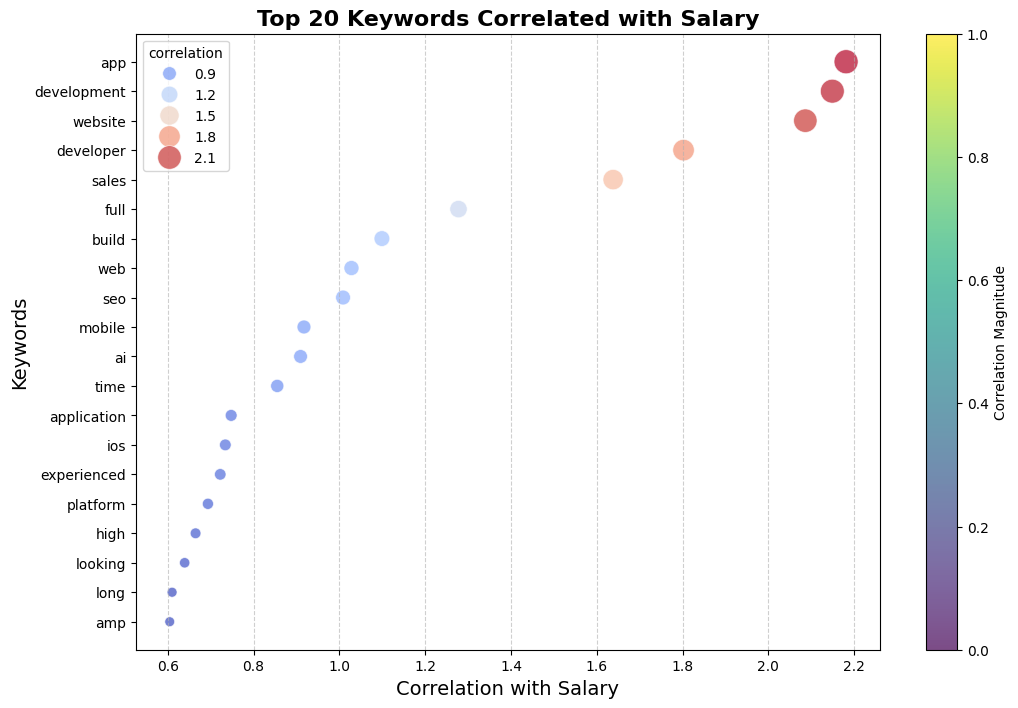

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter Plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=top_keywords['correlation'], y=top_keywords['keyword'],
                hue=top_keywords['correlation'], size=abs(top_keywords['correlation']),
                palette='coolwarm', sizes=(50, 300), alpha=0.7)

plt.title('Top 20 Keywords Correlated with Salary', fontsize=16, fontweight='bold')
plt.xlabel('Correlation with Salary', fontsize=14)
plt.ylabel('Keywords', fontsize=14)

# Adding grid for readability
plt.grid(axis='x', linestyle='--', alpha=0.6)
# Pass the scatter plot object to colorbar
plt.colorbar(scatter.collections[0], label='Correlation Magnitude')

plt.show()

In [51]:
# Assuming 'title_matrix' and 'vectorizer' are already defined from previous steps
keywords = vectorizer.get_feature_names_out()

# Initialize keyword_df to the original Jobs_data DataFrame
keyword_df = Jobs_data.copy()

# Calculate average hourly rate and store it in 'avg_salary'
keyword_df['avg_salary'] = (keyword_df['hourly_low'] + keyword_df['hourly_high']) / 2

# Now 'keywords' is defined and contains the extracted keywords
# Correlation analysis
correlation_results = {}
for keyword in keywords:
    if keyword in keyword_df.columns:  # This check might be unnecessary, you can remove it
        # Assuming X is your feature matrix, and you need to convert to dense
        #X_dense = X.toarray()
        #correlation, _ = pearsonr(X_dense[:, keywords.tolist().index(keyword)], keyword_df['avg_salary'])

        # Accessing columns from the title_matrix using the index of the keyword
        correlation, _ = pearsonr(title_matrix[:, keywords.tolist().index(keyword)].toarray().ravel(), keyword_df['avg_salary'])

        correlation_results[keyword] = correlation

# Convert correlation results to DataFrame
correlation_df = pd.DataFrame(list(correlation_results.items()), columns=['Keyword', 'Correlation'])

# Sort by absolute correlation value for better visualization
correlation_df['AbsCorrelation'] = correlation_df['Correlation'].abs()
correlation_df = correlation_df.sort_values(by='AbsCorrelation', ascending=False).drop(columns=['AbsCorrelation'])

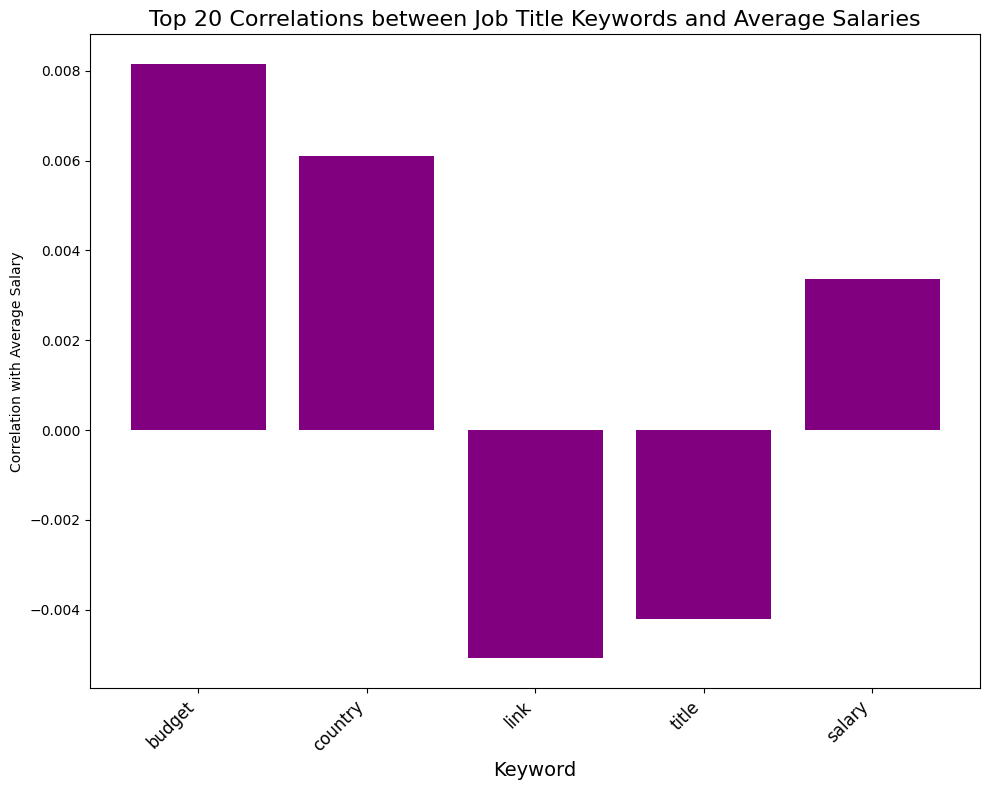

In [52]:
# Plot the top 20 keywords by absolute correlation
top_n = 20
correlation_df_top = correlation_df.head(top_n)

plt.figure(figsize=(10, 8))
# Accessing columns using the correct names (Keyword and Correlation)
plt.bar(correlation_df_top['Keyword'], correlation_df_top['Correlation'], color='purple')  # Changed 'keyword' to 'Keyword'
plt.xlabel('Keyword', fontsize=14)
plt.ylabel('Correlation with Average Salary', fontsize=10)
plt.title('Top 20 Correlations between Job Title Keywords and Average Salaries', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

# Save and show the plot
plt.savefig('correlation_plot.png', dpi=300)
plt.show()

# Save the report
report = correlation_df.to_string(index=False)
with open('correlation_report.txt', 'w') as file:
    file.write(report)

In [53]:
# Assuming you're working with the 'title' column of your 'Jobs_data' DataFrame
from collections import Counter

# Create a list of all words from the 'title' column
all_words = ' '.join(Jobs_data['title'].astype(str).tolist()).split()

# Count the frequency of each word
keyword_counts = Counter(all_words)

# Now you can proceed with your original code
top_10_keywords = keyword_counts.most_common(10)
top_10_keywords_df = pd.DataFrame(top_10_keywords, columns=['Keyword', 'Frequency'])
top_10_keywords

[('for', 73181),
 ('and', 35316),
 ('to', 27496),
 ('a', 27033),
 ('needed', 16672),
 ('-', 16386),
 ('website', 16196),
 ('developer', 15426),
 ('expert', 14552),
 ('in', 14004)]

#Task 2: Identify emerging job categories based on posting frequency

In [54]:
Jobs_data['title'].value_counts().head(10)

,count
title,
social media manager,509
logo design,490
video editor,413
virtual assistant,408
graphic designer,367
youtube video editor,181
lead generation,176
full stack developer,172
logo designer,171


In [55]:
# Extracting job categories
def categorize_job(title):
    if 'Data' in title:
        return 'Data Analyst'
    elif 'Software' in title or 'Engineer' in title:
        return 'Engineering'
    elif 'Project' in title:
        return 'Project Management'
    elif 'Developer' in title:
        return 'Full Stack Developer'
    elif 'Customer' in title:
        return 'Customer Service'
    elif 'Manager' in title:
        return 'Social Media Manager'
    elif 'Assistant' in title:
        return 'Virtual Assistant'
    elif 'Design' in title:
        return 'Logo Design'
    elif 'Editor' in title:
        return 'Video Editor'
    elif 'Designer' in title:
        return 'Graphic Designer'
    elif 'design' in title:
        return 'Logo design'
    elif 'Logo' in title:
        return 'Logo Designer'
    elif 'Website' in title:
        return 'Website Development'
    elif 'Appointment' in title:
        return 'Appointment Setter'
    else:
        return 'Other'

Jobs_data['category'] = Jobs_data['title'].apply(categorize_job)

In [56]:
# Convert 'published_date' column to datetime
Jobs_data['published_date'] = pd.to_datetime(Jobs_data['published_date'], errors='coerce')

In [57]:
Jobs_data

,title,link,published_date,is_hourly,hourly_low,hourly_high,budget,country,avg_salary,salary,average_hourly,category
0,experienced media buyer for solar pannel and r...,https://www.upwork.com/jobs/Experienced-Media-...,2024-02-17 09:09:54+00:00,False,17.339644,41.970610,500.000000,Unknown,29.655127,500.000000,29.655127,Other
1,full stack developer,https://www.upwork.com/jobs/Full-Stack-Develop...,2024-02-17 09:09:17+00:00,False,17.339644,41.970610,1100.000000,United States,29.655127,1100.000000,29.655127,Other
2,smma bubble app,https://www.upwork.com/jobs/SMMA-Bubble-App_%7...,2024-02-17 09:08:46+00:00,True,11.490534,37.044085,20.000000,United States,28.783264,20.000000,24.267310,Other
3,talent hunter specialized in marketing,https://www.upwork.com/jobs/Talent-Hunter-Spec...,2024-02-17 09:08:08+00:00,True,17.339644,41.970610,481.720824,United States,29.655127,481.720824,29.655127,Other
4,data engineer,https://www.upwork.com/jobs/Data-Engineer_%7E0...,2024-02-17 09:07:42+00:00,False,17.339644,41.970610,650.000000,India,29.655127,650.000000,29.655127,Other
...,...,...,...,...,...,...,...,...,...,...,...,...
244823,need facebook advertising experts to launch pr...,https://www.upwork.com/jobs/Need-Facebook-adve...,2024-03-24 13:28:38+00:00,True,20.000000,44.926525,60.000000,Zambia,28.783264,60.000000,32.463262,Other
244824,digital/telemarketing/sales/outside sales,https://www.upwork.com/jobs/Digital-Telemarket...,2024-03-24 13:40:52+00:00,False,17.339644,41.970610,100.000000,Sri Lanka,29.655127,100.000000,29.655127,Other
244825,wordpress template edits,https://www.upwork.com/jobs/WordPress-Template...,2024-03-24 13:37:50+00:00,True,11.490534,37.044085,17.500000,United States,28.783264,17.500000,24.267310,Other
244826,elementor pro for quick fix (wordpress),https://www.upwork.com/jobs/ELEMENTOR-PRO-For-...,2024-03-24 13:52:15+00:00,False,17.339644,41.970610,15.000000,France,29.655127,15.000000,29.655127,Other


In [58]:
# Drop rows with missing 'published_date' or 'title'
Jobs_data.dropna(subset=['published_date', 'title'], inplace=True)

In [59]:
# Extract year and month from the 'published_date'
Jobs_data['year_month'] = Jobs_data['published_date'].dt.to_period('M')

In [60]:
# Group by 'title' and 'year_month' to get the count of job postings for each title per month
job_trends = Jobs_data.groupby(['title', 'year_month']).size().reset_index(name='count')

## Step 2: Calculate Growth Rates
To identify emerging categories, calculate the growth rate over time for each job category.

In [61]:
# Pivot the table to have 'year_month' as index, 'title' as columns, and 'count' as values
job_trends_pivot = job_trends.pivot(index='year_month', columns='title', values='count').fillna(0)

In [62]:
# Calculate the rolling average to smooth the trend (optional)
job_trends_pivot_smooth = job_trends_pivot.rolling(window=3, min_periods=1).mean()

In [63]:
# Calculate the trend for each job title (e.g., slope of the trend line)
trend_data = job_trends_pivot_smooth.reset_index().melt(id_vars='year_month', var_name='title', value_name='count')
trend_summary = trend_data.groupby('title')['count'].apply(lambda x: x.diff().mean()).reset_index(name='trend')

In [64]:
# Get the top emerging job titles by sorting by the trend value
top_emerging_jobs = trend_summary.sort_values(by='trend', ascending=False).head(20)

In [65]:
Jobs_data['title'].value_counts().head(10)

,count
title,
social media manager,509
logo design,490
video editor,413
virtual assistant,408
graphic designer,367
youtube video editor,181
lead generation,176
full stack developer,172
logo designer,171


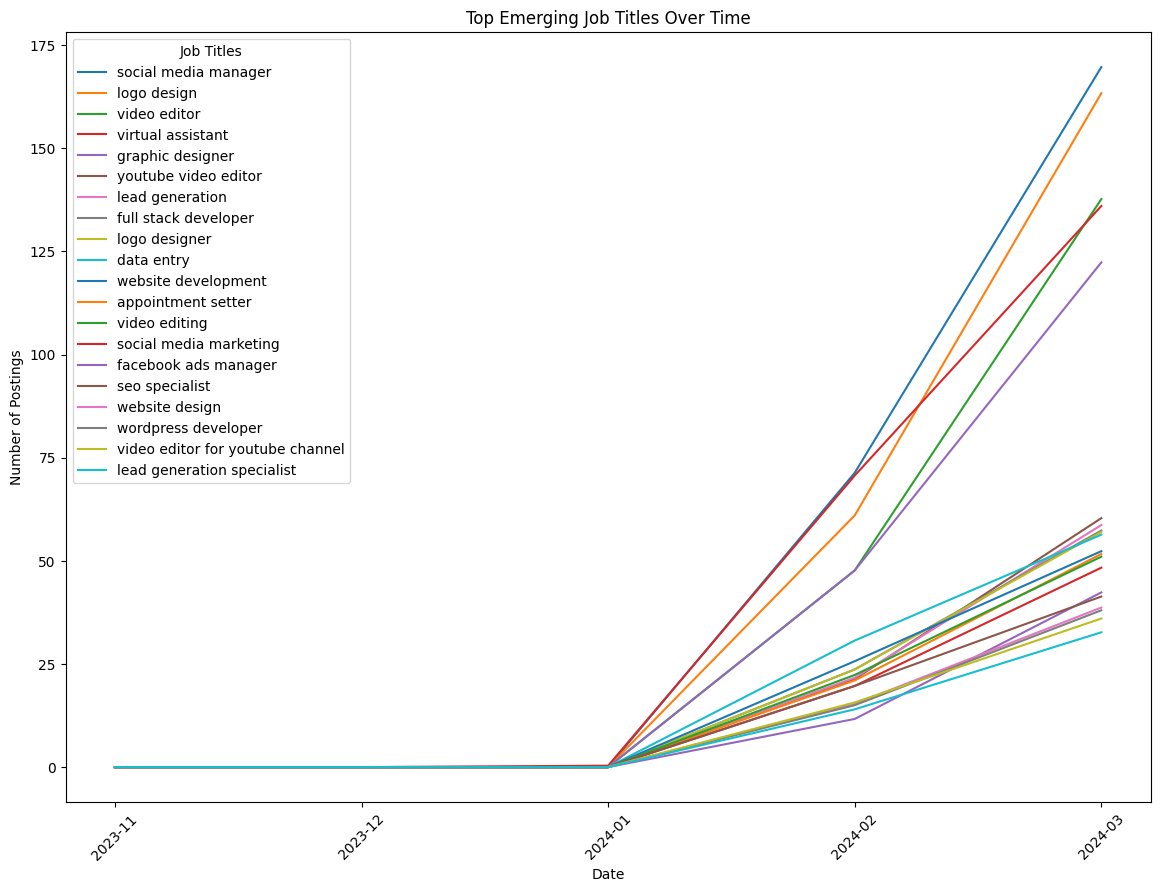

In [66]:
# Plot the trends for the top emerging job titles
plt.figure(figsize=(14, 10))
for job in top_emerging_jobs['title']:
    plt.plot(job_trends_pivot_smooth.index.astype(str), job_trends_pivot_smooth[job], label=job)

plt.title('Top Emerging Job Titles Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Postings')
plt.legend(title='Job Titles')
plt.xticks(rotation=45)
plt.show()

# Task 3: Predict high-demand job roles by analyzing job posting patterns over time

● Objective: To forecast high-demand job roles based on historical job posting data.

● Deliverables: A predictive model with accuracy metrics, and a visual representation of demand trends over time.

# Objective: Predict roles likely to be in high demand based on historical job posting data and trends


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose



In [68]:
 # Forecasting function for each category
def forecast_category(category, data):
    if len(data) < 24:
        print(f"Not enough data for seasonal decomposition for category: {category}")
        return None, None, None

    # Split data into train and test sets
    train_data = data[:-12]
    test_data = data[-12:]

    # Fit the model
    model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=12).fit()

    # Make predictions
    predictions = model.forecast(12)

    # Calculate RMSE
    rmse = mean_squared_error(test_data, predictions, squared=False)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data, label='Train')
    plt.plot(test_data.index, test_data, label='Test')
    plt.plot(predictions.index, predictions, label='Forecast')
    plt.xlabel('Date')
    plt.ylabel('Number of Postings')
    plt.title(f'Forecast for {category} (RMSE: {rmse:.2f})')
    plt.legend()
    plt.show()

    return model, predictions, rmse
# Create monthly_counts DataFrame
# Assuming Jobs_data has 'category' and 'year_month' columns
monthly_counts = Jobs_data.groupby(['year_month', 'category'])['title'].count().unstack(fill_value=0)


# Apply forecasting to each category
results = {}
for category in monthly_counts.columns:
    model, predictions, rmse = forecast_category(category, monthly_counts[category])
    if model:
        results[category] = {'model': model, 'predictions': predictions, 'rmse': rmse}

# Summary of results
for category, result in results.items():
    print(f"Category: {category}, RMSE: {result['rmse']:.2f}")

# Save the models and results
import pickle
with open('forecast_models.pkl', 'wb') as f:
    pickle.dump(results, f)

Not enough data for seasonal decomposition for category: Logo design
Not enough data for seasonal decomposition for category: Other


In [69]:
# Forecasting function for each category
def forecast_category(category, data):
    if len(data) < 24:
        print(f"Not enough data for forecasting for category: {category}")
        return None, None, None

    # Split data into train and test sets
    train_data = data[:-12]
    test_data = data[-12:]

    # Fit the ARIMA model
    model = ARIMA(train_data, order=(1, 1, 1))
    fitted_model = model.fit()

    # Make predictions
    predictions = fitted_model.forecast(steps=len(test_data))

    # Calculate RMSE
    rmse = mean_squared_error(test_data, predictions, squared=False)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data, label='Train')
    plt.plot(test_data.index, test_data, label='Test')
    plt.plot(test_data.index, predictions, label='Forecast')
    plt.xlabel('Date')
    plt.ylabel('Number of Postings')
    plt.title(f'Forecast for {category} (RMSE: {rmse:.2f})')
    plt.legend()
    plt.show()

    return fitted_model, predictions, rmse

# Apply forecasting to each category
results = {}
for category in monthly_counts.index:
    model, predictions, rmse = forecast_category(category, monthly_counts.loc[category])
    if model:
        results[category] = {'model': model, 'predictions': predictions, 'rmse': rmse}

# Summary of results
for category, result in results.items():
    print(f"Category: {category}, RMSE: {result['rmse']:.2f}")

# Save the models and results
import pickle
with open('forecast_models.pkl', 'wb') as f:
    pickle.dump(results, f)

Not enough data for forecasting for category: 2023-11
Not enough data for forecasting for category: 2023-12
Not enough data for forecasting for category: 2024-01
Not enough data for forecasting for category: 2024-02
Not enough data for forecasting for category: 2024-03


# Data Preprocessing

In [70]:
from prophet import Prophet


# Parse dates
Jobs_data['published_date'] = pd.to_datetime(Jobs_data['published_date'])

# Group by job title and month
Jobs_data['month'] = Jobs_data['published_date'].dt.to_period('M')
job_counts = Jobs_data.groupby(['month', 'title']).size().reset_index(name='count')

# Convert 'month' back to datetime
job_counts['month'] = job_counts['month'].dt.to_timestamp()

# Inspect the grouped data
print(job_counts.head())

       month                                              title  count
0 2023-11-01                  senior .net architect (team lead)      1
1 2023-12-01  bookkeeping and collections agent (full time r...      1
2 2023-12-01              data science / computer vision expert      1
3 2023-12-01  i am looking for a research writer to make a s...      1
4 2023-12-01           marketing expert to explode the internet      1


# Preparing Time Series data

In [71]:
def prepare_time_series(Jobs_data, job_title):
    ts_Jobs_data = Jobs_data[Jobs_data['title'] == job_title][['month', 'count']].rename(columns={'month': 'ds', 'count': 'y'})
    return ts_Jobs_data

# Example: Prepare data for 'Full Stack Developer'
job_title = 'Full Stack Developer'
ts_Jobs_data = prepare_time_series(job_counts, job_title)

# Inspect the time series data
print(ts_Jobs_data.head())

# Check for NaN values
print(ts_Jobs_data.isna().sum())

Empty DataFrame
Columns: [ds, y]
Index: []
ds    0
y     0
dtype: int64


In [72]:
if ts_Jobs_data.shape[0] < 2 or ts_Jobs_data['y'].isna().sum() > 0:
    print(f"Not enough data points for job title: {job_title}")
else:
    # Train and forecast
    model = Prophet()
    model.fit(ts_Jobs_data)
    future = model.make_future_dataframe(periods=12, freq='M')  # Forecasting 12 months into the future
    forecast = model.predict(future)

    # Inspect the forecast
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Not enough data points for job title: Full Stack Developer


#Forecasting using Prophet

Evaluating and Visualizing

Accuracy Metrics

In [73]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import random

# Parse dates
Jobs_data['published_date'] = pd.to_datetime(Jobs_data['published_date'])

# Group by job title and month
Jobs_data['month'] = Jobs_data['published_date'].dt.to_period('M')
job_counts = Jobs_data.groupby(['month', 'title']).size().reset_index(name='count')

# Convert 'month' back to datetime
job_counts['month'] = job_counts['month'].dt.to_timestamp()

# Function to prepare time series data
def prepare_time_series(df, job_title):
    ts_df = df[df['title'] == job_title][['month', 'count']].rename(columns={'month': 'ds', 'count': 'y'})
    return ts_df

# Function to forecast demand
def forecast_demand(ts_df):
    model = Prophet()
    model.fit(ts_df)
    future = model.make_future_dataframe(periods=12, freq='M')
    forecast = model.predict(future)
    return forecast


Not enough data points for job title: ecommerce marketing manager spanish
Not enough data points for job title: seeking a klayvio and loyalty/survey techstack expert
Not enough data points for job title: proposal expert for it services
Not enough data points for job title: data entry for company search
Not enough data points for job title: quickbooks setup specialist
Not enough data points for job title: website directory scraping &amp; data mining + linkedin for emails
Not enough data points for job title: seeking hr expert/career coach for career transition
Not enough data points for job title: b2b designer to join marketing team full-time
Not enough data points for job title: hiring manager for germany
Not enough data points for job title: podcast audio quality enhancement
Not enough data points for job title: twitter manager
Not enough data points for job title: middle age female model for women's boutique clothing brand
Not enough data points for job title: create company &amp; pr

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqjle2ivp/9app_1pg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqjle2ivp/ibub95ls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47008', 'data', 'file=/tmp/tmpqjle2ivp/9app_1pg.json', 'init=/tmp/tmpqjle2ivp/ibub95ls.json', 'output', 'file=/tmp/tmpqjle2ivp/prophet_model3ia9xovn/prophet_model-20250110061444.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:14:44 - cmdstanpy - INFO - Chain [1] start processing
IN

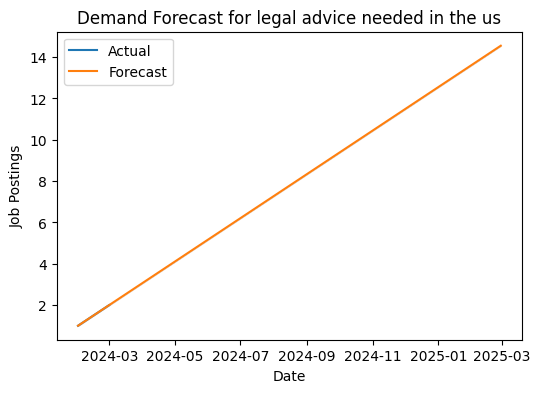

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqjle2ivp/pxe4uep_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqjle2ivp/kgjw3kwz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89703', 'data', 'file=/tmp/tmpqjle2ivp/pxe4uep_.json', 'init=/tmp/tmpqjle2ivp/kgjw3kwz.json', 'output', 'file=/tmp/tmpqjle2ivp/prophet_modelxqewdr6a/prophet_model-20250110061446.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:14:46 - cmdstanpy - INFO - Chain [1] start processing
IN

Not enough data points for proper training/testing split for job title: legal advice needed in the us
Not enough data points for job title: teacher/tutor for after-school activities (music dance stem sports art theater etc.)


06:14:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


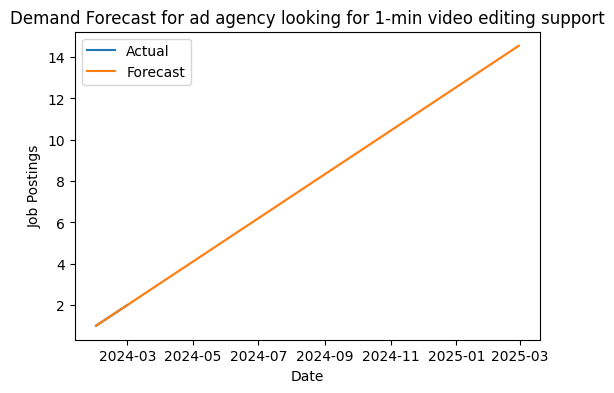

Not enough data points for proper training/testing split for job title: ad agency looking for 1-min video editing support
Not enough data points for job title: ios and android app development: radio player
Not enough data points for job title: research ihg officers and provide contact info
Not enough data points for job title: back-end development of user portal in go
Not enough data points for job title: event photographer - san antonio texas
Not enough data points for job title: expert wordpress &amp; seo professional needed for comprehensive audit and optimization of 4 websites
Not enough data points for job title: online marketing expert needed
Not enough data points for job title: ui/ux designer needed for two visually cohesive websites
Not enough data points for job title: cutter for short form content on social media
Not enough data points for job title: zimfest tshirt design
Not enough data points for job title: square footage measurements of my architectural plan
Not enough da

In [74]:
# Function to plot forecast
def plot_forecast(ts_df, forecast, job_title):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(ts_df['ds'], ts_df['y'], label='Actual')
    ax.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
    ax.set_title(f'Demand Forecast for {job_title}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Job Postings')
    ax.legend()
    plt.show()

# List of unique job titles
job_titles = Jobs_data['title'].unique()

# Sample a subset of job titles (e.g., 10 job titles)
random.seed(42)  # For reproducibility
sampled_job_titles = random.sample(list(job_titles), 100)

# Iterate over each sampled job title
for job_title in sampled_job_titles:
    ts_df = prepare_time_series(job_counts, job_title)

    # Ensure there are enough data points
    if ts_df.shape[0] < 2 or ts_df['y'].isna().sum() > 0:
        print(f"Not enough data points for job title: {job_title}")
        continue

    # Train and forecast
    forecast = forecast_demand(ts_df)
    plot_forecast(ts_df, forecast, job_title)

    # Calculate MAE
    split_date = '2023-01-01'
    train = ts_df[ts_df['ds'] < split_date]
    test = ts_df[ts_df['ds'] >= split_date]

    # Check for sufficient data points for training/testing split
    if train.shape[0] < 2 or test.shape[0] < 1:
        print(f"Not enough data points for proper training/testing split for job title: {job_title}")
        continue

    model = Prophet()
    model.fit(train)
    future = model.make_future_dataframe(periods=len(test), freq='M')
    forecast = model.predict(future)

    y_true = test['y'].values
    y_pred = forecast.loc[forecast['ds'].isin(test['ds']), 'yhat'].values
    mae = mean_absolute_error(y_true, y_pred)
    print(f'MAE for {job_title}: {mae}')

print("Processing completed.")

In [75]:
import pandas as pd

# Parse dates
Jobs_data['published_date'] = pd.to_datetime(Jobs_data['published_date'],errors='coerce')

# Normalize titles
Jobs_data['title'] = Jobs_data['title'].str.lower().str.strip()
title_replacements = {
    'logo designer': 'logo design',
    'logo design': 'logo design'
}
Jobs_data['title'] = Jobs_data['title'].replace(title_replacements)

# Group by 'published_date' and 'title'
grouped_data = Jobs_data.groupby(['published_date', 'title']).size()
print(grouped_data.head(10))

published_date             title                                                                                  
2023-11-02 09:22:02+00:00  senior .net architect (team lead)                                                          1
2023-12-02 19:07:53+00:00  video editor for ecommerce ads needed.                                                     1
2023-12-05 13:01:33+00:00  urgently hiring!! inside sales agents for a long term position with generous commission    1
2023-12-11 12:07:13+00:00  swedish content writer needed                                                              1
2023-12-13 18:42:59+00:00  recruiter (full time/permanent/long term)                                                  1
2023-12-16 01:06:41+00:00  marketing expert to explode the internet                                                   1
2023-12-20 20:26:36+00:00  bookkeeping and collections agent (full time role) at a fast growing company!              1
2023-12-21 13:27:18+00:00  data science / com

In [76]:
# Extracting month and year from 'published_date'
Jobs_data['month'] = Jobs_data['published_date'].dt.month
Jobs_data['year'] = Jobs_data['published_date'].dt.year

# Aggregating job postings by category and month-year
Jobs_data['month_year'] = Jobs_data['published_date'].dt.to_period('M')
job_demand = Jobs_data.groupby(['category', 'month_year']).size().reset_index(name='count')

# Pivoting data for clustering
pivot_df = job_demand.pivot(index='category', columns='month_year', values='count').fillna(0)

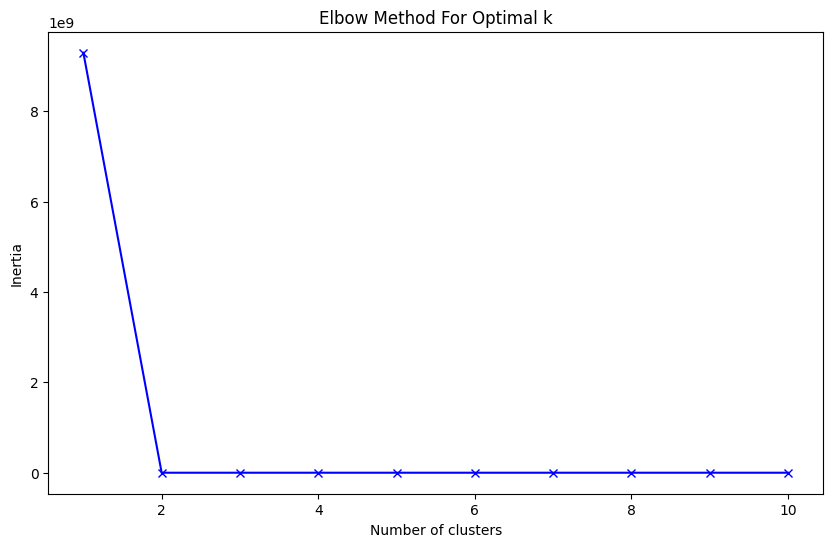

In [77]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Determining the number of clusters using the elbow method
inertia = []
K = range(1, 11)  # Consider reducing the range if you have few samples
for k in K:
    # Ensure k is less than or equal to the number of samples
    k = min(k, pivot_df.shape[0])
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pivot_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Applying K-means with an optimal number of clusters
# Ensure optimal_k is less than or equal to the number of samples
optimal_k = min(3, pivot_df.shape[0])
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
pivot_df['cluster'] = kmeans.fit_predict(pivot_df)

## Key Interpretations:
Elbow Method Outcome:

The "elbow point" from the inertia curve suggests the number of clusters that efficiently groups the data.
Fewer clusters may oversimplify the data, while too many clusters can lead to overfitting or redundancy.

Clustering Outcome:
The new cluster column divides the data into groups based on their
similarity.
Each cluster represents a distinct subgroup, which can reveal insights like:
Segmentation of job roles based on skills or salaries.
Grouping of customers in market analysis.
Classification of regions or industries.

Real-World Applications:
In a job market analysis project:
Clusters might represent job categories or industries (e.g., tech, healthcare, finance).
Helps target job recommendations for specific user profiles.

In [78]:
# Convert all column names to strings
pivot_df.columns = pivot_df.columns.astype(str)

# Check for non-numeric columns and convert if necessary
numeric_columns = pivot_df.select_dtypes(include=['number']).columns
pivot_df = pivot_df[numeric_columns]

#Apply kmeans clustering with k=2

In [79]:
from sklearn.cluster import KMeans

# Apply K-means with the determined number of clusters (k=2)
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
pivot_df['cluster'] = kmeans.fit_predict(pivot_df)

Visualize the clusters

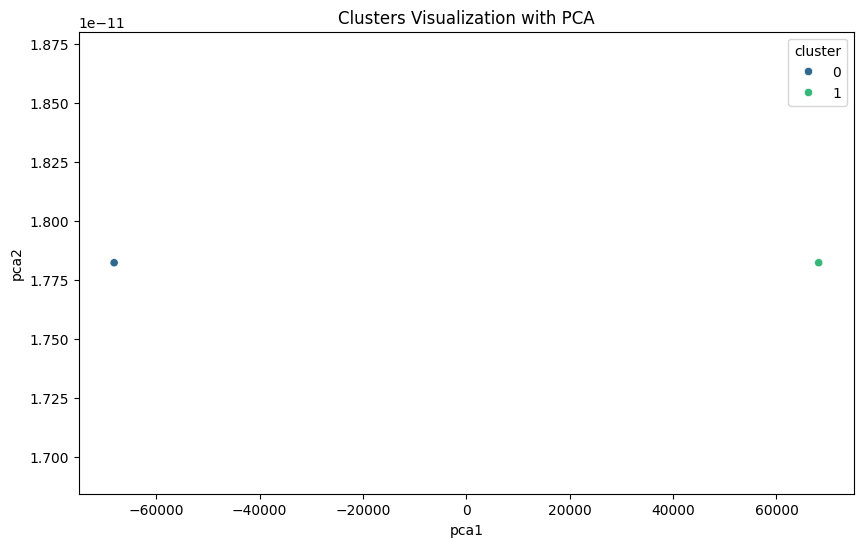

In [80]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
pivot_df['pca1'] = pca.fit_transform(pivot_df.drop(columns=['cluster']))[:, 0]
pivot_df['pca2'] = pca.fit_transform(pivot_df.drop(columns=['cluster']))[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=pivot_df, palette='viridis')
plt.title('Clusters Visualization with PCA')
plt.show()

#

In [81]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# In ipython-input-266-c23b034acffe, change the following line:
# job_demand['month_year'] = job_demand['month_year'].dt.to_timestamp()
# to:

job_demand['month_year'] = job_demand['month_year'].dt.to_timestamp() if job_demand['month_year'].dtype == 'period[M]' else job_demand['month_year']

for cluster_num in range(optimal_k):
    clustered_categories = pivot_df[pivot_df['cluster'] == cluster_num].index

    for category in clustered_categories:
        series = job_demand[job_demand['category'] == category].set_index('month_year')['count']

        if len(series) >= 24:  # Ensure at least 24 months of data
            model = ExponentialSmoothing(series, seasonal='add', seasonal_periods=12).fit()
        else:
            try:
                # Try fitting with a different initialization method
                model = ExponentialSmoothing(series, seasonal='add', seasonal_periods=12, initialization_method='heuristic').fit()
            except ValueError:
                print(f"Skipping category {category} in cluster {cluster_num} due to insufficient data")
                continue

        forecast = model.forecast(steps=12)

        plt.figure(figsize=(10, 6))
        plt.plot(series, label='Historical')
        plt.plot(forecast, label='Forecast', linestyle='--')
        plt.title(f'Forecast for {category} (Cluster {cluster_num})')
        plt.legend()
        plt.show()

Skipping category Logo design in cluster 0 due to insufficient data
Skipping category Other in cluster 1 due to insufficient data


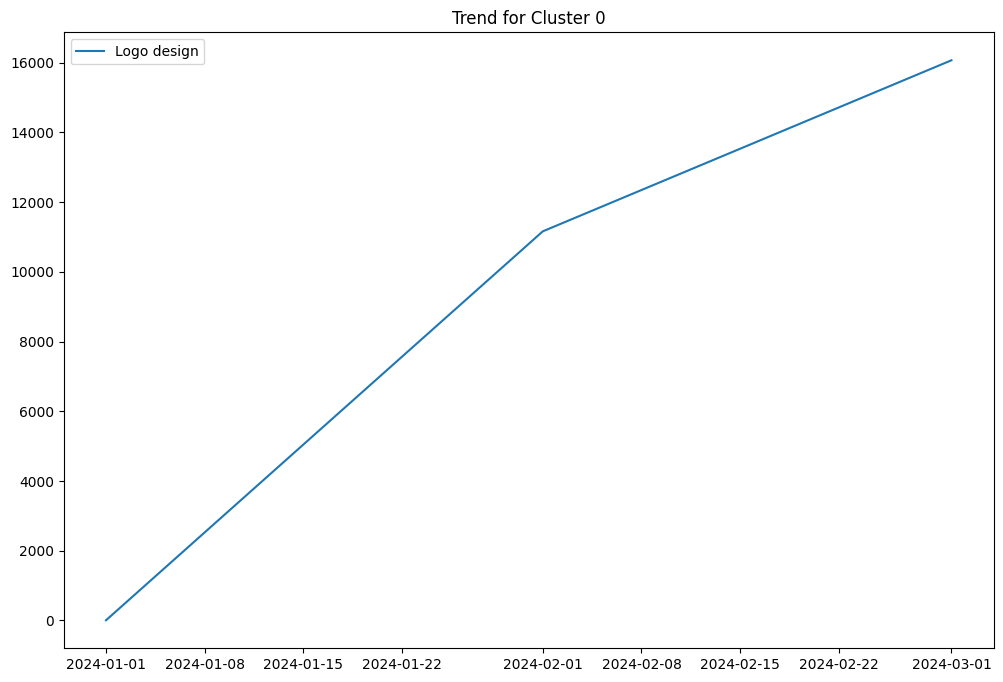

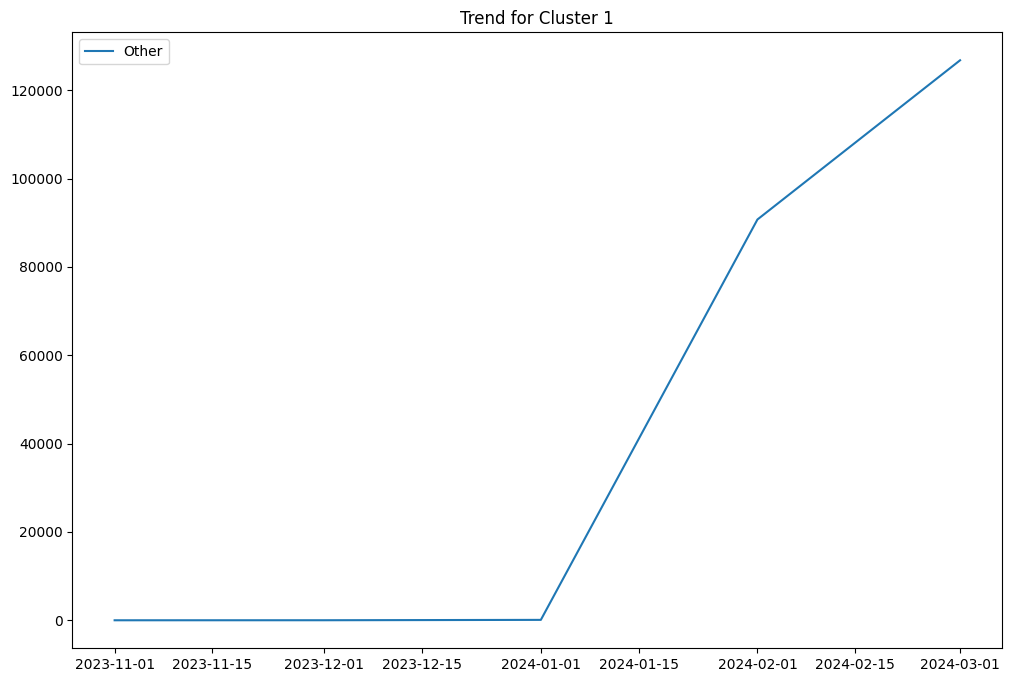

In [82]:
import matplotlib.pyplot as plt

# Visualizing the trends for all clusters
for i in range(optimal_k):
    clustered_categories = pivot_df[pivot_df['cluster'] == i].index
    plt.figure(figsize=(12, 8))
    for category in clustered_categories:
        series = job_demand[job_demand['category'] == category].set_index('month_year')['count']
        plt.plot(series, label=category)
    plt.title(f'Trend for Cluster {i}')
    plt.legend()
    plt.show()

# To visualizes the time-series trends of job demand for categories within each cluster. By doing so, it helps identify patterns and behaviors specific to different clusters

#Fetch Data for Each Category:

Filters the job_demand dataframe for the specific category.
Sets month_year as the index (time-series) and retrieves the corresponding job demand counts.


In [83]:
# Ensure 'month_year' is a datetime object if not already
# Correct way to convert Period objects to Timestamps
job_demand['month_year'] = job_demand['month_year'].dt.to_timestamp() if hasattr(job_demand['month_year'].dt, 'to_timestamp') else job_demand['month_year']

In [84]:
# Filter for a specific job title (e.g., 'Data Scientist')
job_title_data = job_counts[job_counts['title'] == 'Data Scientist']
job_title_data['month_year'] = job_title_data['month']  # Add month_year column

# Check if there's enough data for decomposition
if job_title_data.shape[0] < 24:
    print(f"Not enough data points for job title: Data Scientist to perform seasonal decomposition. Found: {job_title_data.shape[0]}")
else:
    # Plot the trend
    plt.figure(figsize=(12, 6))
    plt.plot(job_title_data['month_year'], job_title_data['count'], label='Job Postings')
    plt.title('Trend of Data Scientist Job Postings')
    plt.xlabel('Time')
    plt.ylabel('Number of Postings')
    plt.legend()
    plt.show()

    # Seasonal decomposition
    result = seasonal_decompose(job_title_data.set_index('month_year')['count'], model='additive', period=12)
    result.plot()
    plt.show()

Not enough data points for job title: Data Scientist to perform seasonal decomposition. Found: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqjle2ivp/5hlghk17.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqjle2ivp/2h61r9ef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61393', 'data', 'file=/tmp/tmpqjle2ivp/5hlghk17.json', 'init=/tmp/tmpqjle2ivp/2h61r9ef.json', 'output', 'file=/tmp/tmpqjle2ivp/prophet_modelx6uwe9n4/prophet_model-20250110061455.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:14:55 - cmdstanpy - INFO - Chain [1] start processing
IN

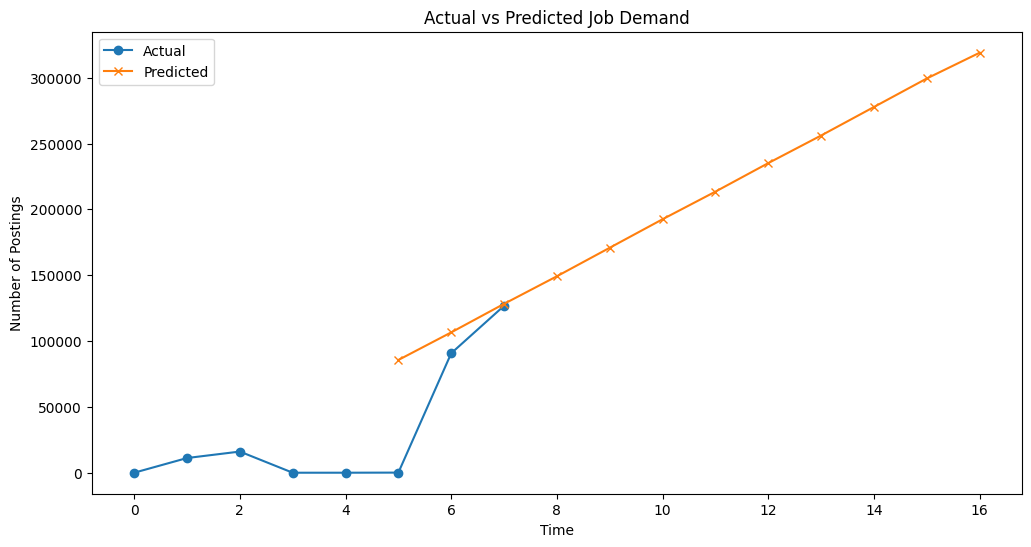

In [85]:
# Visualize predictions vs actual

# Assuming you have a DataFrame named 'job_demand'
# with columns 'category', 'month_year', and 'count'

# ... (your code to prepare and fit a forecasting model)...

# Example using Prophet:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# Create and fit a Prophet model
model = Prophet()
model.fit(job_demand[['month_year', 'count']].rename(columns={'month_year': 'ds', 'count': 'y'}))

# Make future predictions
future = model.make_future_dataframe(periods=12, freq='M')  # Forecasting for 12 months ahead
forecast = model.predict(future)

# Extract the last 12 months as the test set
y_test = job_demand['count'][-12:]  # Actual values for the last 12 months
y_pred = forecast['yhat'][-12:]  # Predicted values for the last 12 months

# ... (rest of your plotting code)...
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Job Demand')
plt.xlabel('Time')
plt.ylabel('Number of Postings')
plt.legend()
plt.show()

#Evaluates a forecasting model's performance by comparing actual job demand with predicted values for the last 12 months. It also provides a visual representation of how well the model captures historical trends.

##Visualizes how well the model's predictions align with the actual job demand.
#Includes markers (o for actual, x for predicted) for clear distinction

#For Job Market Analysis:

#Predict future demand to guide job seekers or hiring managers.
#Anticipate peaks or declines in job postings, aiding in workforce planning.




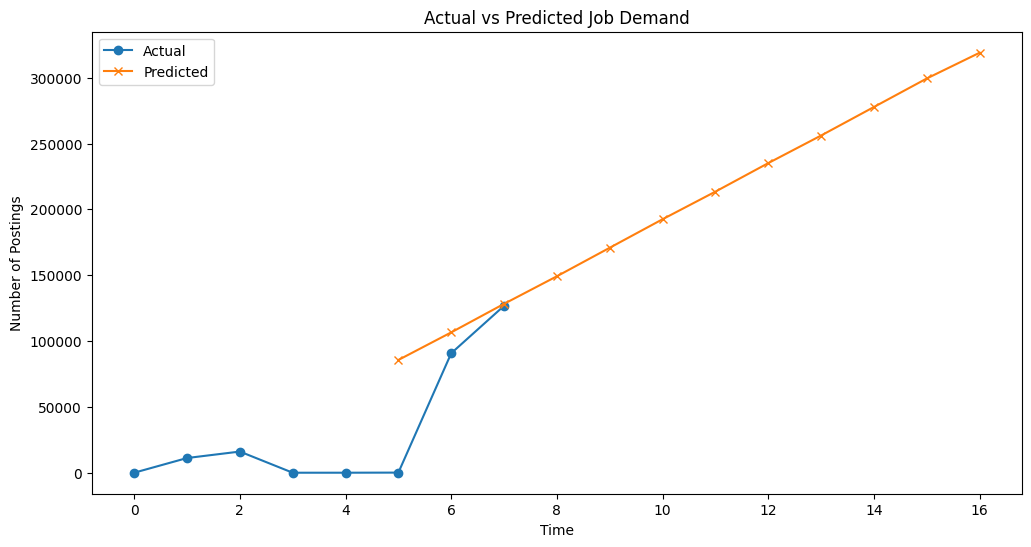

In [86]:
# Visualize predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Job Demand')
plt.xlabel('Time')
plt.ylabel('Number of Postings')
plt.legend()
plt.show()


In [87]:
forecast[['ds', 'yhat']].head()


,ds,yhat
0,2023-11-01,-19860.399315
1,2023-12-01,1096.715255
2,2024-01-01,22752.400292
3,2024-02-01,44408.085282
4,2024-03-01,64666.629492


# ds: The date for the prediction.

#yhat: The predicted number of job postings on that date.

# Deliverables
Task 1: Correlation analysis and visualizations for high-value keywords and salaries.

Task 2: Time-series plots for emerging job categories and a ranked list of high-growth categories.

Task 3: Predictive models (e.g., Prophet) and visualized trends for high-demand roles.

In [88]:
Jobs_data.to_csv('all_upwork_jobs_next.csv')